In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scdna_replication_tools.plot_utils import plot_cell_cn_profile2, plot_clustered_cell_cn_matrix, get_htert_cmap

In [2]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

despine_offset = 0
despine_trim = True

### Load and preprocess the data which allows me to compare sample CNAs vs ancestral RT

In [3]:
def load_rt_data(datasets, rt_paths):
    # load dataset pseudobulk rt profiles
    rt = pd.DataFrame()
    for d in datasets:
        temp_rt = pd.read_csv(rt_paths.format(d), sep='\t')
        if 'SA039' in d:
            temp_rt = temp_rt[[
                'chr', 'start', 'pseudobulk_cloneA_model_rep_state', 'pseudobulk_cloneA_hours', 'pseudobulk_model_rep_state', 'pseudobulk_hours'
            ]]
            temp_rt.rename(columns={
                'pseudobulk_cloneA_model_rep_state': '{}_cloneA_pseudobulk_rt'.format(d),
                'pseudobulk_cloneA_hours': '{}_cloneA_pseudobulk_rt_hours'.format(d)
            }, inplace=True)
        else:
            temp_rt = temp_rt[[
                'chr', 'start', 'pseudobulk_model_rep_state', 'pseudobulk_hours',
            ]]
        temp_rt.rename(columns={
            'pseudobulk_model_rep_state': '{}_pseudobulk_rt'.format(d),
            'pseudobulk_hours': '{}_pseudobulk_rt_hours'.format(d)
        }, inplace=True)
        
        if rt.empty:
            rt = temp_rt
        else:
            rt = pd.merge(rt, temp_rt)

    # set chr column to category
    rt.chr = rt.chr.astype('str')
    rt.chr = rt.chr.astype('category')

    rt['end'] = rt['start'] + 500000 - 1
            
    return rt
    

def load_cn_data(datasets, cn_paths):
    # load dataset pseudobulk cn profiles
    cn = pd.DataFrame()

    col_name_change = {}
    for d in datasets:
        temp_cn = pd.read_csv(cn_paths.format(d), sep='\t')
        temp_cn = temp_cn.set_index(['chr', 'start'])
        
        # find the sample level pseudobulk cn column
        # note that it can start with dataset or sample prefix
        col_of_interest = [c for c in temp_cn.columns if c.startswith('dataset')]
        if len(col_of_interest)==0:
            col_of_interest = [c for c in temp_cn.columns if c.startswith('sample')]
        temp_cn = temp_cn[col_of_interest].reset_index()
        
        col_name_change[col_of_interest[0]] = '{}_pseudobulk_cn'.format(d)
        
        if cn.empty:
            cn = temp_cn
        else:
            cn = pd.merge(cn, temp_cn)


    # set chr column to category
    cn.chr = cn.chr.astype('str')
    cn.chr = cn.chr.astype('category')

    cn['end'] = cn['start'] + 500000 - 1

    cn = cn.rename(columns=col_name_change)

    return cn


In [4]:
def make_bk(cn, datasets):
    # create a table of copy number breakpoints for sample pseudobulk data
    # copy over the chromosome, start, and end columns
    cn_breakpoints = cn[['chr', 'start', 'end']].copy()
    for d in datasets:
        # create a column for the copy number breakpoints
        cn_breakpoints['{}_pseudobulk_cn_breakpoints'.format(d)] = cn['{}_pseudobulk_cn'.format(d)].diff().fillna(0).astype('int')
        # convert all nonzero values to 1
        cn_breakpoints['{}_pseudobulk_cn_breakpoints'.format(d)] = cn_breakpoints['{}_pseudobulk_cn_breakpoints'.format(d)].apply(lambda x: 1 if x!=0 else 0)

    return cn_breakpoints


def compute_relative_rt_and_cn(cn, rt, datasets):
    for d in datasets:
        ref_rt_col = 'SA039_cloneA_pseudobulk_rt'
        ref_cn_col = 'SA039_pseudobulk_cn'
        
        temp_rt_col = '{}_pseudobulk_rt'.format(d)
        temp_cn_col = '{}_pseudobulk_cn'.format(d)
        
        relative_rt_col = '{}_pseudobulk_relative_rt'.format(d)
        relative_cn_col = '{}_pseudobulk_relative_cn'.format(d)
        
        rt[relative_rt_col] = rt[temp_rt_col] - rt[ref_rt_col]
        cn[relative_cn_col] = (cn[temp_cn_col] / cn[temp_cn_col].mode().values[0]) - (cn[ref_cn_col] / cn[ref_cn_col].mode().values[0])
    
    return cn, rt


def merge_cn_and_rt_info(cn, rt, bk, datasets):
    # merge the cn and rt tables into one long-form dataframe
    df = []

    for d in datasets:
        ref_rt_col = 'SA039_cloneA_pseudobulk_rt'
        ref_cn_col = 'SA039_pseudobulk_cn'
        
        temp_rt_col = '{}_pseudobulk_rt'.format(d)
        temp_cn_col = '{}_pseudobulk_cn'.format(d)
        temp_bk_col = '{}_pseudobulk_cn_breakpoints'.format(d)
        
        relative_rt_col = '{}_pseudobulk_relative_rt'.format(d)
        relative_cn_col = '{}_pseudobulk_relative_cn'.format(d)
        
        temp_df = pd.DataFrame({
            'chr': cn['chr'], 'start': cn['start'], 'end': cn['end'], 'dataset': [d]*cn.shape[0],
            'WT_pseudobulk_rt': rt[ref_rt_col], 'WT_pseudobulk_cn': cn[ref_cn_col],
            'pseudobulk_rt': rt[temp_rt_col], 'pseudobulk_cn': cn[temp_cn_col], 'pseudobulk_bk': bk[temp_bk_col],
            'relative_rt': rt[relative_rt_col], 'relative_cn': cn[relative_cn_col]
        })
        
        df.append(temp_df)

    df = pd.concat(df, ignore_index=True)

    return df

In [15]:
def load_clone_rt_data(datasets, rt_paths):
    # load dataset pseudobulk rt profiles
    rt = pd.DataFrame()
    for d in datasets:
        temp_rt = pd.read_csv(rt_paths.format(d), sep='\t')
        # set chr and start as the index columns
        temp_rt = temp_rt.set_index(['chr', 'start'])
        # subset to only the columns containing 'clone' and 'model_rep_state' substrings
        temp_rt = temp_rt[[c for c in temp_rt.columns if 'clone' in c and 'model_rep_state' in c]]
        # add the dataset d as the prefix for all the column names
        temp_rt = temp_rt.add_prefix('{}_'.format(d))
        # remove the 'pseudobulk_' substring from the column names
        temp_rt = temp_rt.rename(columns={c: c.replace('pseudobulk_', '') for c in temp_rt.columns})
        # replace the 'model_rep_state' substring with 'pseudobulk_rt' in the column names
        temp_rt = temp_rt.rename(columns={c: c.replace('model_rep_state', 'pseudobulk_rt') for c in temp_rt.columns})
        
        # reset the index
        temp_rt = temp_rt.reset_index()
        if rt.empty:
            rt = temp_rt
        else:
            rt = pd.merge(rt, temp_rt)

    # set chr column to category
    rt.chr = rt.chr.astype('str').astype('category')

    rt['end'] = rt['start'] + 500000 - 1
            
    return rt
    

def load_clone_cn_data(datasets, cn_paths):
    # load dataset pseudobulk cn profiles
    cn = pd.DataFrame()

    for d in datasets:
        temp_cn = pd.read_csv(cn_paths.format(d), sep='\t')

        # set chr and start as the index columns
        temp_cn = temp_cn.set_index(['chr', 'start'])
        # subset to only the columns containing 'clone' and 'model_rep_state' substrings
        temp_cn = temp_cn[[c for c in temp_cn.columns if 'clone' in c]]
        # add the dataset d as the prefix for all the column names
        temp_cn = temp_cn.add_prefix('{}_'.format(d))
        # replace the 'clone_' substring with 'clone' in the column names
        temp_cn = temp_cn.rename(columns={c: c.replace('clone_', 'clone') for c in temp_cn.columns})
        # add the '_pseudobulk_cn' suffix to the column names
        temp_cn = temp_cn.rename(columns={c: '{}_pseudobulk_cn'.format(c) for c in temp_cn.columns})

        # reset the index
        temp_cn = temp_cn.reset_index()
        
        if cn.empty:
            cn = temp_cn
        else:
            cn = pd.merge(cn, temp_cn)


    # set chr column to category
    cn.chr = cn.chr.astype('str').astype('category')

    cn['end'] = cn['start'] + 500000 - 1

    return cn

In [22]:
def make_bk_clones(cn, clones):
    # create a table of copy number breakpoints for sample pseudobulk data
    # copy over the chromosome, start, and end columns
    cn_breakpoints = cn[['chr', 'start', 'end']].copy()
    for c in clones:
        # create a column for the copy number breakpoints
        cn_breakpoints['{}_pseudobulk_cn_breakpoints'.format(c)] = cn['{}_pseudobulk_cn'.format(c)].diff().fillna(0).astype('int')
        # convert all nonzero values to 1
        cn_breakpoints['{}_pseudobulk_cn_breakpoints'.format(c)] = cn_breakpoints['{}_pseudobulk_cn_breakpoints'.format(c)].apply(lambda x: 1 if x!=0 else 0)

    return cn_breakpoints


def compute_relative_rt_and_cn_clones(cn, rt, clones):
    for c in clones:
        ref_rt_col = 'SA039_cloneA_pseudobulk_rt'
        ref_cn_col = 'SA039_cloneA_pseudobulk_cn'
        
        temp_rt_col = '{}_pseudobulk_rt'.format(c)
        temp_cn_col = '{}_pseudobulk_cn'.format(c)
        
        relative_rt_col = '{}_pseudobulk_relative_rt'.format(c)
        relative_cn_col = '{}_pseudobulk_relative_cn'.format(c)
        
        rt[relative_rt_col] = rt[temp_rt_col] - rt[ref_rt_col]
        cn[relative_cn_col] = (cn[temp_cn_col] / cn[temp_cn_col].mode().values[0]) - (cn[ref_cn_col] / cn[ref_cn_col].mode().values[0])
    
    return cn, rt


def merge_cn_and_rt_info_clones(cn, rt, bk, clones):
    # merge the cn and rt tables into one long-form dataframe
    df = []

    for c in clones:
        ref_rt_col = 'SA039_cloneA_pseudobulk_rt'
        ref_cn_col = 'SA039_cloneA_pseudobulk_cn'
        
        temp_rt_col = '{}_pseudobulk_rt'.format(c)
        temp_cn_col = '{}_pseudobulk_cn'.format(c)
        temp_bk_col = '{}_pseudobulk_cn_breakpoints'.format(c)
        
        relative_rt_col = '{}_pseudobulk_relative_rt'.format(c)
        relative_cn_col = '{}_pseudobulk_relative_cn'.format(c)
        
        temp_df = pd.DataFrame({
            'chr': cn['chr'], 'start': cn['start'], 'end': cn['end'], 'clone': [c]*cn.shape[0],
            'WT_pseudobulk_rt': rt[ref_rt_col], 'WT_pseudobulk_cn': cn[ref_cn_col],
            'pseudobulk_rt': rt[temp_rt_col], 'pseudobulk_cn': cn[temp_cn_col], 'pseudobulk_bk': bk[temp_bk_col],
            'relative_rt': rt[relative_rt_col], 'relative_cn': cn[relative_cn_col]
        })
        
        df.append(temp_df)

    df = pd.concat(df, ignore_index=True)

    return df

In [17]:
datasets = [
    'SA039', 'SA906a', 'SA906b', 'SA1292', 'SA1056', 'SA1188', 'SA1054', 'SA1055'
]
rt_paths = 'scdna_replication_paper/analysis/sig_lines/{}/scRT_pseudobulks.tsv'
cn_paths = 'scdna_replication_paper/analysis/sig_lines/{}/cn_pseudobulks.tsv'

# load the rt and cn data
rt_clone = load_clone_rt_data(datasets, rt_paths)
cn_clone = load_clone_cn_data(datasets, cn_paths)

# remove the site of p53 deletion on chr17
chr17_start_thresh = 21000001
cn_clone = cn_clone.loc[~((cn_clone['chr'] == '17') & (cn_clone['start'] <= chr17_start_thresh))]
rt_clone = rt_clone.loc[~((rt_clone['chr'] == '17') & (rt_clone['start'] <= chr17_start_thresh))]
rt_clone.head()

,chr,start,SA039_cloneA_pseudobulk_rt,SA039_cloneB_pseudobulk_rt,SA039_cloneC_pseudobulk_rt,SA039_cloneD_pseudobulk_rt,SA906a_cloneA_pseudobulk_rt,SA906a_cloneB_pseudobulk_rt,SA906a_cloneC_pseudobulk_rt,SA906a_cloneD_pseudobulk_rt,...,SA1055_cloneB_pseudobulk_rt,SA1055_cloneC_pseudobulk_rt,SA1055_cloneD_pseudobulk_rt,SA1055_cloneE_pseudobulk_rt,SA1055_cloneF_pseudobulk_rt,SA1055_cloneG_pseudobulk_rt,SA1055_cloneH_pseudobulk_rt,SA1055_cloneI_pseudobulk_rt,SA1055_cloneJ_pseudobulk_rt,end
0,1,1000001,0.944694,0.954,0.935065,1.000000,0.829268,0.785714,0.533333,0.909375,...,0.5,1.0,1.000000,0.8,0.8,1.0,1.0,0.914286,1.0,1500000
1,1,1500001,0.949178,0.968,0.952381,1.000000,0.959350,0.878571,0.866667,0.943750,...,0.5,1.0,0.833333,0.6,0.6,1.0,1.0,0.885714,1.0,2000000
2,1,2000001,0.955157,0.968,0.952381,0.972973,0.878049,0.828571,0.555556,0.900000,...,0.5,1.0,1.000000,0.8,0.8,1.0,1.0,0.914286,1.0,2500000
3,1,3000001,0.877429,0.910,0.891775,0.972973,0.878049,0.707143,0.577778,0.843750,...,0.5,1.0,1.000000,0.8,0.6,1.0,1.0,0.771429,1.0,3500000
4,1,4000001,0.765321,0.830,0.753247,0.864865,0.878049,0.757143,0.755556,0.743750,...,0.5,1.0,1.000000,0.6,0.6,1.0,1.0,0.771429,0.8,4500000


In [18]:
cn_clone.head()

,chr,start,SA039_cloneA_pseudobulk_cn,SA039_cloneB_pseudobulk_cn,SA039_cloneC_pseudobulk_cn,SA039_cloneD_pseudobulk_cn,SA906a_cloneA_pseudobulk_cn,SA906a_cloneB_pseudobulk_cn,SA906a_cloneC_pseudobulk_cn,SA906a_cloneD_pseudobulk_cn,...,SA1055_cloneB_pseudobulk_cn,SA1055_cloneC_pseudobulk_cn,SA1055_cloneD_pseudobulk_cn,SA1055_cloneE_pseudobulk_cn,SA1055_cloneF_pseudobulk_cn,SA1055_cloneG_pseudobulk_cn,SA1055_cloneH_pseudobulk_cn,SA1055_cloneI_pseudobulk_cn,SA1055_cloneJ_pseudobulk_cn,end
0,1,1000001,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,4.0,4.0,3.0,2.0,2.0,4.0,4.0,2.0,4.0,1500000
1,1,1500001,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,4.0,4.0,3.0,2.0,2.0,4.0,4.0,2.0,4.0,2000000
2,1,2000001,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,4.0,4.0,3.0,2.0,2.0,4.0,4.0,2.0,4.0,2500000
3,1,3000001,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,4.0,4.0,3.0,2.0,2.0,4.0,4.0,2.0,4.0,3500000
4,1,4000001,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,4.0,4.0,3.0,2.0,2.0,4.0,4.0,2.0,4.0,4500000


In [23]:
htert_clones = [c.replace('_pseudobulk_cn', '') for c in cn_clone.set_index(['chr', 'start', 'end']).columns.tolist()]

# make a table of copy number breakpoints
bk_clone = make_bk_clones(cn_clone, htert_clones)

# compute the relative RT and CN values for each dataset
cn_clone, rt_clone = compute_relative_rt_and_cn_clones(cn_clone, rt_clone, htert_clones)

# merge the cn and rt tables into one long-form dataframe
df_clone = merge_cn_and_rt_info_clones(cn_clone, rt_clone, bk_clone, htert_clones)

# create column to denote whether a particular bin has a gain, loss, or no cna
df_clone['cna_type'] = 'unaltered'
for i, row in df_clone.iterrows():
    if row['relative_cn'] > 0:
        df_clone.loc[i, 'cna_type'] = 'gain'
    elif row['relative_cn'] < 0:
        df_clone.loc[i, 'cna_type'] = 'loss'

# rename bk column
df_clone['breakpoint'] = df_clone['pseudobulk_bk'].replace({0: 'No', 1: 'Yes'})
df_clone.head()

,chr,start,end,clone,WT_pseudobulk_rt,WT_pseudobulk_cn,pseudobulk_rt,pseudobulk_cn,pseudobulk_bk,relative_rt,relative_cn,cna_type,breakpoint
0,1,1000001,1500000,SA039_cloneA,0.944694,2.0,0.944694,2.0,0,0.0,0.0,unaltered,No
1,1,1500001,2000000,SA039_cloneA,0.949178,2.0,0.949178,2.0,0,0.0,0.0,unaltered,No
2,1,2000001,2500000,SA039_cloneA,0.955157,2.0,0.955157,2.0,0,0.0,0.0,unaltered,No
3,1,3000001,3500000,SA039_cloneA,0.877429,2.0,0.877429,2.0,0,0.0,0.0,unaltered,No
4,1,4000001,4500000,SA039_cloneA,0.765321,2.0,0.765321,2.0,0,0.0,0.0,unaltered,No


In [24]:
len(htert_clones)

61

In [27]:
def get_cna_cmap():
    ''' Global color map for copy number alterations '''
    cmap = {
        'gain': 'red',  # red
        'loss': 'deepskyblue',  # dark blue
        'neutral': '#CCCCCC',  # grey
        'unaltered': '#CCCCCC'  # grey
    }
    return cmap

In [38]:
def ancestral_rt_vs_clone_cna_histogram(df, ax):
    # histogram of RT values split by CNA type
    df['CNA type'] = df['cna_type']
    sns.histplot(
        data=df, x='WT_pseudobulk_rt', hue='CNA type', 
        common_norm=False, stat='density', ax=ax, kde=True,
        palette=get_cna_cmap(), cbar_kws={'edgecolor': 'k', 'linewidth': 0}
    )
    ax.set_xlabel('SA039 clone A (diploid WT) RT\n<--late | early-->')
    ax.set_title('Location of subclonal CNAs')

    # compute a p-value for the difference in RT between bins with different CNA types
    # multiply each p-value by 3 because we are doing 3 pairwise comparisons (bonferonni correction)
    gain = df.query('`CNA type`=="gain"')['WT_pseudobulk_rt']
    unaltered = df.query('`CNA type`=="unaltered"')['WT_pseudobulk_rt']
    loss = df.query('`CNA type`=="loss"')['WT_pseudobulk_rt']
    gain_unaltered_pval = stats.ttest_ind(gain, unaltered)[1] * 3
    gain_loss_pval = stats.ttest_ind(gain, loss)[1] * 3
    loss_unaltered_pval = stats.ttest_ind(loss, unaltered)[1] * 3

    # add p-values to plot
    ax.text(0.5, 0.9, 'gain-unalt p={:.2e}'.format(gain_unaltered_pval), transform=ax.transAxes, ha='center', va='center')
    ax.text(0.5, 0.8, 'gain-loss p={:.2e}'.format(gain_loss_pval), transform=ax.transAxes, ha='center', va='center')
    ax.text(0.5, 0.7, 'loss-unalt p={:.2e}'.format(loss_unaltered_pval), transform=ax.transAxes, ha='center', va='center')


def plot_clone_cn_profiles(cn, ax, clones, chrom_labels_to_remove=[]):
    # plot the relative sample CN profiles for each dataset
    cmap = get_htert_cmap()
    for i, c in enumerate(clones):
        d = c.split('_')[0]
        relative_cn_col = '{}_pseudobulk_relative_cn'.format(c)
        # plot pseudobulk cn values for this dataset
        if 'cloneA' in c:
            plot_cell_cn_profile2(
                ax, cn, relative_cn_col, color=cmap[d], rawy=True, s=1,
                max_cn=None, scale_data=False, lines=True, label=d, rasterized=True,
                chrom_labels_to_remove=chrom_labels_to_remove
            )
        else:
            plot_cell_cn_profile2(
                ax, cn, relative_cn_col, color=cmap[d], rawy=True, s=1,
                max_cn=None, scale_data=False, lines=True, label='', rasterized=True,
                chrom_labels_to_remove=chrom_labels_to_remove
            )
    ax.set_title('Clone pseudobulk CN')
    ax.set_ylabel('ploidy-normalized CN\n<--losses | gains-->')
    ax.legend(ncol=2)

    # manually set the y-ticks for ax[1] to range from -1 to 1, spaced by 0.2
    ax.set_yticks(np.arange(-1, 5, 0.5))
    ax.spines['left'].set_bounds(-1, 4.5)


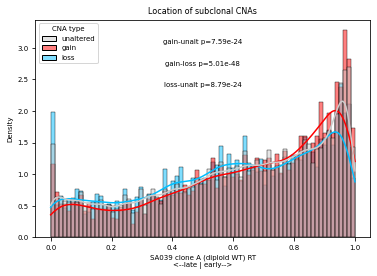

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a f

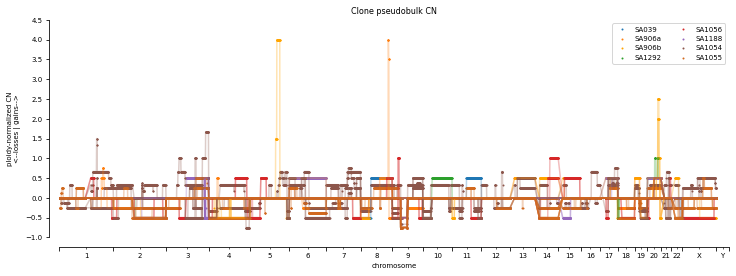

In [39]:
# plot the ancestral_rt_vs_clone_cna_histogram
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ancestral_rt_vs_clone_cna_histogram(df_clone, ax)
plt.show()

# plot the clone cn profiles
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plot_clone_cn_profiles(cn_clone, ax, htert_clones)
plt.show()

In [5]:
# datasets = [
#     'SA039', 'SA906a', 'SA906b', 'SA1292', 'SA1056', 'SA1188', 'SA1054', 'SA1055'
# ]
# rt_paths = 'scdna_replication_paper/analysis/sig_lines/{}/scRT_pseudobulks.tsv'
# cn_paths = 'scdna_replication_paper/analysis/sig_lines/{}/cn_pseudobulks.tsv'

# # load the rt and cn data
# rt = load_rt_data(datasets, rt_paths)
# cn = load_cn_data(datasets, cn_paths)

# # remove the site of p53 deletion on chr17
# chr17_start_thresh = 21000001
# cn = cn.loc[~((cn['chr'] == '17') & (cn['start'] <= chr17_start_thresh))]
# rt = rt.loc[~((rt['chr'] == '17') & (rt['start'] <= chr17_start_thresh))]

# # make a table of copy number breakpoints
# bk = make_bk(cn, datasets)

# # compute the relative RT and CN values for each dataset
# cn, rt = compute_relative_rt_and_cn(cn, rt, datasets)

# # merge the cn and rt tables into one long-form dataframe
# df = merge_cn_and_rt_info(cn, rt, bk, datasets)

# # create column to denote whether a particular bin has a gain, loss, or no cna
# df['cna_type'] = 'unaltered'
# for i, row in df.iterrows():
#     if row['relative_cn'] > 0:
#         df.loc[i, 'cna_type'] = 'gain'
#     elif row['relative_cn'] < 0:
#         df.loc[i, 'cna_type'] = 'loss'

# # rename bk column
# df['breakpoint'] = df['pseudobulk_bk'].replace({0: 'No', 1: 'Yes'})

# df.head()

,chr,start,end,dataset,WT_pseudobulk_rt,WT_pseudobulk_cn,pseudobulk_rt,pseudobulk_cn,pseudobulk_bk,relative_rt,relative_cn,cna_type,breakpoint
0,1,1000001,1500000,SA039,0.944694,2.0,0.947808,2.0,0,0.003114,0.0,unaltered,No
1,1,1500001,2000000,SA039,0.949178,2.0,0.957550,2.0,0,0.008373,0.0,unaltered,No
2,1,2000001,2500000,SA039,0.955157,2.0,0.959638,2.0,0,0.004481,0.0,unaltered,No
3,1,3000001,3500000,SA039,0.877429,2.0,0.893528,2.0,0,0.016099,0.0,unaltered,No
4,1,4000001,4500000,SA039,0.765321,2.0,0.788448,2.0,0,0.023127,0.0,unaltered,No


### Make functions for plotting the relationship between ancestral RT and sample CNAs

In [7]:
def ancestral_rt_vs_sample_cna_histogram(df, ax):
    # histogram of RT values split by CNA type
    df['CNA type'] = df['cna_type']
    sns.histplot(
        data=df.query('dataset!="SA039"'), x='WT_pseudobulk_rt', hue='CNA type', 
        common_norm=False, stat='density', ax=ax, kde=True,
        palette=get_cna_cmap(), cbar_kws={'edgecolor': 'k', 'linewidth': 0}
    )
    ax.set_xlabel('SA039 clone A (diploid WT) RT\n<--late | early-->')
    ax.set_title('Location of clonal CNAs')

    # compute a p-value for the difference in RT between bins with different CNA types
    # multiply each p-value by 3 because we are doing 3 pairwise comparisons (bonferonni correction)
    gain = df.query('dataset!="SA039" and `CNA type`=="gain"')['WT_pseudobulk_rt']
    unaltered = df.query('dataset!="SA039" and `CNA type`=="unaltered"')['WT_pseudobulk_rt']
    loss = df.query('dataset!="SA039" and `CNA type`=="loss"')['WT_pseudobulk_rt']
    gain_unaltered_pval = stats.ttest_ind(gain, unaltered)[1] * 3
    gain_loss_pval = stats.ttest_ind(gain, loss)[1] * 3
    loss_unaltered_pval = stats.ttest_ind(loss, unaltered)[1] * 3

    # add p-values to plot
    ax.text(0.5, 0.9, 'gain-unalt p={:.2e}'.format(gain_unaltered_pval), transform=ax.transAxes, ha='center', va='center')
    ax.text(0.5, 0.8, 'gain-loss p={:.2e}'.format(gain_loss_pval), transform=ax.transAxes, ha='center', va='center')
    ax.text(0.5, 0.7, 'loss-unalt p={:.2e}'.format(loss_unaltered_pval), transform=ax.transAxes, ha='center', va='center')



In [8]:
def plot_ancestral_wt_rt_profile(rt, ax, chrom_labels_to_remove=[]):
    # plot the reference RT profile
    # get the reference pseudobulk rt column
    ref_rt_col = 'SA039_cloneA_pseudobulk_rt'
    # plot pseudobulk rt values of the reference WT dataset
    plot_cell_cn_profile2(
        ax, rt, ref_rt_col, rawy=True, color='C0', s=1,
        max_cn=None, scale_data=False, lines=True, rasterized=True,
        chrom_labels_to_remove=chrom_labels_to_remove
    )
    ax.set_title('SA039 clone A (diploid WT)')
    ax.set_ylabel('Pseudobulk RT\n<--late | early-->')


def plot_sample_cn_profiles(cn, ax, datasets, chrom_labels_to_remove=[]):
    # plot the relative sample CN profiles for each dataset
    cmap = get_htert_cmap()
    for i, d in enumerate(datasets):
        relative_cn_col = '{}_pseudobulk_relative_cn'.format(d)
        # plot pseudobulk cn values for this dataset
        plot_cell_cn_profile2(
            ax, cn, relative_cn_col, color=cmap[d], rawy=True, s=1,
            max_cn=None, scale_data=False, lines=True, label=d, rasterized=True,
            chrom_labels_to_remove=chrom_labels_to_remove
        )
    ax.set_title('Sample pseudobulk CN')
    ax.set_ylabel('ploidy-normalized CN\n<--losses | gains-->')
    ax.legend(ncol=2)

    # manually set the y-ticks for ax[1] to range from -1 to 1, spaced by 0.2
    ax.set_yticks(np.arange(-1, 1.2, 0.2))
    ax.spines['left'].set_bounds(-1, 1)

### Load and preprocess the data that shows clone pseudobulk CN profiles for SA1292

In [9]:
# load long-form dataframes from different cell cycle phases
bulk_cn_SA1292 = pd.read_csv('scdna_replication_paper/analysis/sig_lines/SA1292/cn_pseudobulks.tsv', sep='\t')

# treat each pseudobulk profile as a unique cell_id
bulk_df_SA1292 = bulk_cn_SA1292.melt(id_vars=['chr', 'start'], var_name='cell_id', value_name='state')

# cluster_id corresponds to whether each profile is dataset, sample or clone level
bulk_df_SA1292['cluster_id'] = bulk_df_SA1292['cell_id'].apply(lambda x: x.split('_')[0])
# name of the dataset, sample or clone
bulk_df_SA1292['clone_id'] = bulk_df_SA1292['cell_id'].apply(lambda x: x.split('_')[1])

# replace underscores with spaces in cell_id column
bulk_df_SA1292['cell_id'] = bulk_df_SA1292['cell_id'].apply(lambda x: x.replace('_', ' '))

bulk_df_SA1292[['cell_id', 'cluster_id', 'clone_id']].drop_duplicates()

,cell_id,cluster_id,clone_id
0,dataset SA1292,dataset,SA1292
5451,sample AT135,sample,AT135
10902,clone A,clone,A
16353,clone B,clone,B
21804,clone C,clone,C


### Plot the clone CN profiles as a clustered heatmap for SA1292

In [10]:
def plot_sorted_clone_profiles(bulk_df, dataset, ax, chrom_labels_to_remove=[]):
    # subset the bulk_df to just the clone level profiles
    bulk_df = bulk_df.query('cluster_id=="clone"')
    
    plot_data = plot_clustered_cell_cn_matrix(
        ax, bulk_df, 'state', cluster_field_name='cluster_id', secondary_field_name='clone_id', chrom_boundary_width=0.5, chrom_labels_to_remove=chrom_labels_to_remove
    )
    labels = plot_data.columns.get_level_values(0).values
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels)
    ax.set_title('{}: clone pseudobulk CN'.format(dataset))


### Load and preprocess data that shows RT shifts at regions affected by subclonal CNAs

In [11]:
rt_shifts = pd.read_csv('scdna_replication_paper/analysis/sig_lines/subclonal_rt_diffs_summary.tsv', sep='\t')
rt_shifts.head()

,chr,start,end,reference_rt,clone_rt,clone_rt_diff,clone_cna_type,dataset
0,11,66000001,66500000,0.991187,0.972,-0.019187,gain,SA039
1,11,66500001,67000000,0.990740,0.994,0.003260,gain,SA039
2,11,67000001,67500000,0.990190,0.992,0.001810,gain,SA039
3,11,67500001,68000000,0.967987,0.980,0.012013,gain,SA039
4,11,68000001,68500000,0.959226,0.972,0.012774,gain,SA039


In [12]:
def subclonal_rt_shift_histogram(df, ax, title_prefix):
    # show the histogram of clone_rt_diff with a hue of clone_cna_type
    sns.histplot(
        data=df, x='clone_rt_diff', hue='clone_cna_type', hue_order=['loss', 'unaltered', 'gain'], 
        palette=get_cna_cmap(), common_norm=False, stat='density', ax=ax,
        cbar_kws={'edgecolor': 'k', 'linewidth': 0}, kde=True
    )

    # compute the p-values between loss-unaltered and gain-unaltered
    # get the y-values for the loss-unaltered and gain-unaltered comparisons
    loss = df[df.clone_cna_type == 'loss'].clone_rt_diff
    unaltered = df[df.clone_cna_type == 'unaltered'].clone_rt_diff
    gain = df[df.clone_cna_type == 'gain'].clone_rt_diff
    # compute the p-value between loss-unaltered and gain-unaltered
    # multiply by 3 because we are doing 3 tests (bonferroni correction)
    loss_unaltered_pval = stats.ttest_ind(loss, unaltered)[1] * 3
    gain_unaltered_pval = stats.ttest_ind(gain, unaltered)[1] * 3
    gain_loss_pval = stats.ttest_ind(gain, loss)[1] * 3

    # annotate the p-values in the upper-left corner
    ax.text(0.05, 0.9, 'gain-unalt p={:.2e}'.format(gain_unaltered_pval), transform=ax.transAxes, ha='left', va='center')
    ax.text(0.05, 0.8, 'gain-loss p={:.2e}'.format(gain_loss_pval), transform=ax.transAxes, ha='left', va='center')
    ax.text(0.05, 0.7, 'loss-unalt p={:.2e}'.format(loss_unaltered_pval), transform=ax.transAxes, ha='left', va='center')

    # annotate the median of each distribution with a dashed vertical line
    # annotate the line with the median value as text with 2 decimal places
    loss_median = df[df.clone_cna_type=='loss'].clone_rt_diff.median()
    ax.axvline(x=loss_median, color=get_cna_cmap()['loss'], linestyle='--')
    # ax.text(x=loss_median, y=10, s='median={:.2f}'.format(loss_median), color=get_cna_cmap()['loss'], ha='left', va='center')
    unaltered_median = df[df.clone_cna_type=='unaltered'].clone_rt_diff.median()
    ax.axvline(x=unaltered_median, color=get_cna_cmap()['unaltered'], linestyle='--')
    # ax.text(x=unaltered_median, y=12, s='median={:.2f}'.format(unaltered_median), color=get_cna_cmap()['unaltered'], ha='left', va='center')
    gain_median = df[df.clone_cna_type=='gain'].clone_rt_diff.median()
    ax.axvline(x=gain_median, color=get_cna_cmap()['gain'], linestyle='--')
    # ax.text(x=gain_median, y=10, s='median={:.2f}'.format(gain_median), color=get_cna_cmap()['gain'], ha='right', va='center')

    ax.set_title('{}: RT shifts at subclonal CNAs'.format(title_prefix))
    ax.set_xlabel('Clone RT relative to reference\n<--later | earlier-->')
    ax.set_xlim(-0.3, 0.3)
    # add xticks and xticklabels from -0.3 to 0.3 spaced by 0.1
    # round each value to 1 decimal place
    ax.set_xticks(np.arange(-0.3, 0.4, 0.1))
    ax.set_xticklabels(np.arange(-0.3, 0.4, 0.1).round(1))
    # remove the legend from the plot
    ax.legend().remove()

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a f

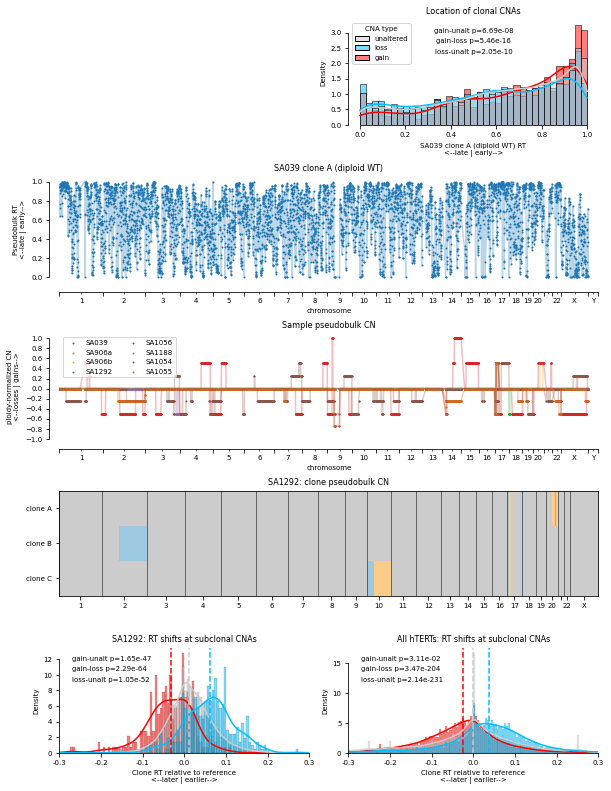

In [13]:
# create figure
fig, ax = plt.subplots(5, 2, figsize=(8.5, 11), tight_layout=True)

chrom_labels_to_remove = ['21']

# merge the two subplots in the 2nd row
ax[1, 0].remove()
ax[1, 1].remove()
ax[1, 0] = fig.add_subplot(5, 2, (3, 4))

# merge the two subplots in the 3rd row
ax[2, 0].remove()
ax[2, 1].remove()
ax[2, 0] = fig.add_subplot(5, 2, (5, 6))

# merge the two subplots in the 4th row
ax[3, 0].remove()
ax[3, 1].remove()
ax[3, 0] = fig.add_subplot(5, 2, (7, 8))

# make the top left plot invisible
ax[0, 0].set_visible(False)

# plot the histogram of ancestral RT values split by CNA type in the top right subplot
ancestral_rt_vs_sample_cna_histogram(df, ax[0, 1])
sns.despine(ax=ax[0, 1], offset=despine_offset, trim=despine_trim)

# plot the ancestral WT RT profile the the 2nd row
plot_ancestral_wt_rt_profile(rt, ax[1, 0], chrom_labels_to_remove=chrom_labels_to_remove)

# plot the sample CN profiles in the 3rd row
plot_sample_cn_profiles(cn, ax[2, 0], datasets, chrom_labels_to_remove=chrom_labels_to_remove)

# plot the sorted clone CN profiles for SA1292 in the 4th row
plot_sorted_clone_profiles(bulk_df_SA1292, 'SA1292', ax[3, 0], chrom_labels_to_remove=chrom_labels_to_remove)

# plot the rt shifts for SA1292 in the bottom left subplot
subclonal_rt_shift_histogram(rt_shifts.query('dataset=="SA1292"'), ax[4, 0], 'SA1292')
sns.despine(ax=ax[4, 0], offset=despine_offset, trim=despine_trim)

# plot the rt shifts for all hTERTs in the bottom right subplot
subclonal_rt_shift_histogram(rt_shifts, ax[4, 1], 'All hTERTs')
sns.despine(ax=ax[4, 1], offset=despine_offset, trim=despine_trim)

# fig.savefig('scdna_replication_paper/plots/sig_lines/main_figure_draft.pdf', bbox_inches='tight', dpi=300)

plt.show()